# Highlight Fibers with Hessian-Based "Vesselness"

In [1]:
import matplotlib.pylab as plt
%matplotlib inline

from pathlib import Path
import numpy as np

from skimage.morphology import skeletonize
import itk
from distutils.version import StrictVersion as VS
if VS(itk.Version.GetITKVersion()) < VS("5.0.0"):
    print("ITK 5.0.0 or newer is required.")
    sys.exit(1)
import skan
import sys
import os
sys.path.append(str(Path(os.getcwd()) / '..' / 'src' ))
from skan_extensions import FilterableSkeleton
from itkwidgets import view, compare

In [2]:
DATA_DIR = Path('../data')

In [3]:
file_name = str(DATA_DIR / 'larson_roi.tif')

In [4]:
image = itk.imread(file_name, itk.UC)

In [5]:
view(image, vmin=80, shadow=False, gradient_opacity=0.3, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.3, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy o…

In [6]:
view(image, vmin=80, mode='z', ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkImagePython.itkImageU…

In [7]:
sigma = 4.0
hessian = itk.hessian_recursive_gaussian_image_filter(image, sigma=sigma)
vesselness_filter = itk.Hessian3DToVesselnessMeasureImageFilter[itk.ctype('float')].New(hessian)
vesselness_filter.Update()
vesselness = vesselness_filter.GetOutput()
view(vesselness, mode='z', vmax=0.5)

Viewer(geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkImagePython.itkImageF…

In [8]:
compare(image, vesselness, gradient_opacity=0.2, shadow=False, mode='z')

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [9]:
thresh = itk.otsu_threshold_image_filter(vesselness)
compare(vesselness, thresh, interpolate=False, mode='z')

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

In [10]:
inverted = itk.invert_intensity_image_filter(thresh)

In [11]:
skeleton = itk.medial_thickness_image_filter3_d(inverted)

In [12]:
csr_skeleton = skan.csr.Skeleton(itk.array_from_image(skeleton))

In [13]:
view(geometries=csr_skeleton)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [14]:
branch_data = skan.summarize(csr_skeleton)
branch_data.head()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
0,1,1,333,4.000000,0,1.0,0.0,0.0,68.0,23.0,4.0,68.0,23.0,0.0,68.0,23.0,4.0,68.0,23.0,4.000000
1,2,2,353,4.000000,0,1.0,0.0,0.0,97.0,221.0,4.0,97.0,221.0,0.0,97.0,221.0,4.0,97.0,221.0,4.000000
2,3,3,639,5.000000,0,1.0,0.0,0.0,289.0,299.0,5.0,289.0,299.0,0.0,289.0,299.0,5.0,289.0,299.0,5.000000
3,4,4,44797,219.071068,0,1.0,0.0,1.0,2.0,9.0,218.0,4.0,6.0,1.0,2.0,9.0,218.0,4.0,6.0,217.029952
4,5,5,480,4.828427,0,1.0,0.0,1.0,2.0,261.0,5.0,2.0,261.0,1.0,2.0,261.0,5.0,2.0,261.0,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aacb3eb3f90>,
      dtype=object)

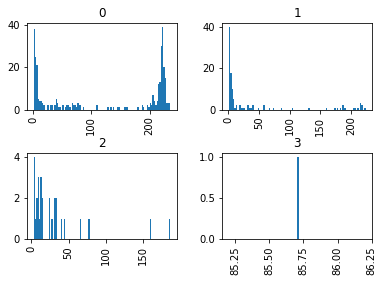

In [15]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100)

In [16]:
statistics = skan.csr.branch_statistics(csr_skeleton.graph)

# Columns are: branch endpoint IDs, length, branch type, average pixel value along graph
statistics

array([[1.00000000e+00, 3.33000000e+02, 4.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 3.53000000e+02, 4.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 6.39000000e+02, 5.00000000e+00, 0.00000000e+00],
       ...,
       [4.49400000e+04, 4.51300000e+04, 3.00000000e+00, 0.00000000e+00],
       [4.49510000e+04, 4.50780000e+04, 2.73205081e+00, 0.00000000e+00],
       [3.98620000e+04, 4.50790000e+04, 2.73205081e+00, 1.00000000e+00]])

In [17]:
fcsr_skeleton = FilterableSkeleton(itk.array_from_image(skeleton))

In [18]:
fcsr_skeleton.remove_paths(min_length=100.0, branch_types=range(1))
fcsr_skeleton.n_paths

198

In [19]:
view(geometries=[fcsr_skeleton])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  2.,  3.,  1.,
         1.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  3.,  0.,  3.,  4.,
         6.,  1.,  2.,  1.,  3.,  2.,  6., 11.,  6., 14., 15., 25., 21.,
        11., 12., 10.,  4.,  2.,  1.,  3.,  1.,  2.]),
 array([104.50986092, 105.81891658, 107.12797223, 108.43702789,
        109.74608354, 111.0551392 , 112.36419486, 113.67325051,
        114.98230617, 116.29136182, 117.60041748, 118.90947313,
        120.21852879, 121.52758444, 122.8366401 , 124.14569576,
        125.45475141, 126.76380707, 128.07286272, 129.38191838,
        130.69097403, 132.00002969, 133.30908534, 134.618141  ,
        135.92719666, 137.23625231, 138.54530797, 

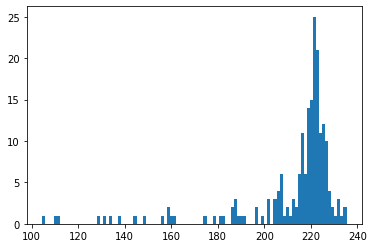

In [20]:
plt.hist(fcsr_skeleton.distances, bins=100)